# Reproduce Figures
1. Coverage vs. Atypicality Quantile, for any experimental setting
2. Coefficients $\beta$ for 3x3 Experimental Settings Using Atypicality 
3. Mean Coverage, Mean $\beta$, and Mean MSE from the Mean for values of $\lambda$
4. Coverage vs. Beta for values of $\lambda$


In [1]:
import sys
sys.path.append("../src")
import pickle

from atypicality import compute_atypicality_scores
from data_generation_settings import split_and_scale_data, generate_and_split_mvn_data, generate_and_split_lognormal_data, \
        generate_and_split_gmm_data, load_and_split_chd_data, load_and_split_mimic_data
from fit_cp_models import fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model
from compute_bounds import evaluate_lambda_adjusted_interval_coverage
from compute_betas import compute_beta
from lambda_tuning import lambda_hyperparameter_tuning, run_lambda_selection_and_evaluation
from plotting import plot_coverage_across_atypicality_quantile, plot_betagrouped_by_atypicality, plot_lambda_metrics, \
    avg_coverage_by_attr_witherror, heatmap_by_quantile_attribute, plot_mean_demographic_composition

# 1. Calculating Coverage vs. Atypicality Quantile for any experimental setting
Generate a plot of coverage across atypicality quantile. The `evaluate_lambda_adjusted_interval_coverage` function creates a dataframe with coverage for each quantile and specified experimental settings. The `plot_coverage_across_atypicality_quantile` filters the dataframe by specified `atypicality_score` and plots coverage across quantiles for different $\lambda$ values. 

* In `atypicality_settings`, specify which atypicality scores to use: `knn_score`, `kde_score`, `logjointmvn_score`, `lognormal_score`, and `gmm_score`. For each score, specify a corresponding $\lambda$ value by which to adjust the bounds. Recall that the `lognormal_score` assumes positive target y; make sure to only use the `lognormal_score` in the `generate_and_split_lognormal_data` data gneration setting or else the function will return an error.
* Specify which data generation setting to use: `generate_and_split_mvn_data`, `generate_and_split_lognormal_data`, and `generate_and_split_gmm_data`.
* Specify which conformal prediction algorithm to use: `fit_rf_cp_model`, `fit_gaussian_cp_model`, `fit_conformal_cp_model`
* When `true_atypicality=True`, we use the true atypicality value. When `true_atypicality=False`, we use the predicted atypicality value.
* When `return_df=True`, the second value of the returned tuple will contain predictions, lower and upper intervals generated by the CP algorithm, and adjusted intervals according to $\lambda$. 
* `silent` mutes print statements from the internal functions, reporting status. 

In our paper, we use `n_samples = 5000`, `n_splits=5`, and `num_quantiles = 5`. 

In [2]:
atypicality_settings = [
    ('logjointmvn_score', 0),
    # ('knn_score', 1)
]

# Run calibration across all atypicality types
coverage_by_quantile_lambda, df = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=generate_and_split_lognormal_data, 
                                        fit_cp_model=fit_gaussian_cp_model, 
                                        n_samples=5000,
                                        n_splits=5, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        silent=True)

# Peek at output: coverage across atypicality score, quantile, split, and lambda
coverage_by_quantile_lambda.head(5)

,score,lambda,quantile,coverage,split
0,logjointmvn_score,0,0,0.980,0
1,logjointmvn_score,0,1,0.985,0
2,logjointmvn_score,0,2,0.945,0
3,logjointmvn_score,0,3,0.790,0
4,logjointmvn_score,0,4,0.335,0


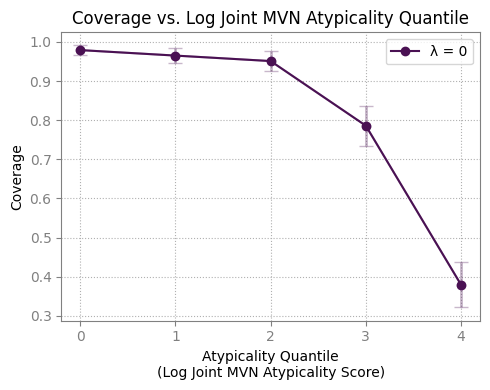

In [4]:
# Plot result for a specific atypicality score
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)

# 2. Calculate $\beta$ for 3x3 Experimental Settings Using Atypicality
Our paper demonstreates the utility of atypicality by calculating the coefficient for coverage vs. atypicality quantile across several data generation settings, conformal prediction algorithms, and atypicality scores. The following code uses `compute_beta` to regenerate the figure, iterating across all experimental settings. 

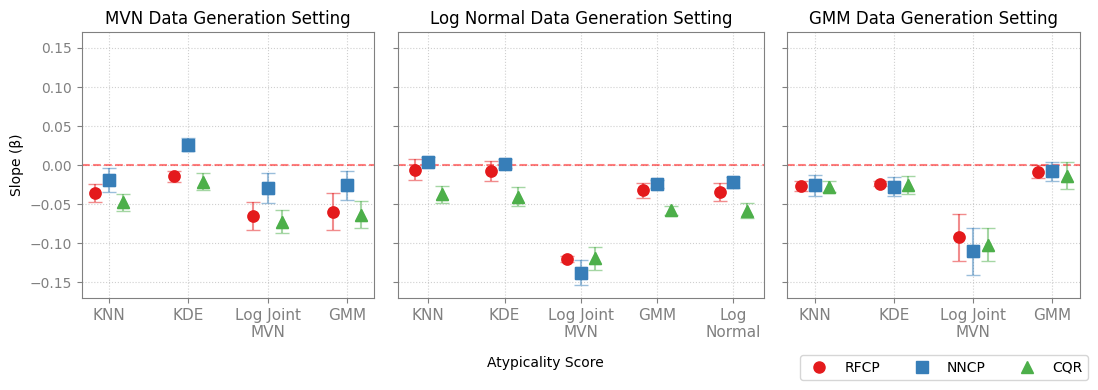

In [5]:
# Takes 353min to run
beta_df = compute_beta(true_atypicality=True, silent=True)
beta_df.to_csv('../intermediate/3x3_trueatypicality.csv', index=False)
plot_betagrouped_by_atypicality(beta_df=beta_df, true_atypicality=True, outputfile="3x3_atypicality.png")

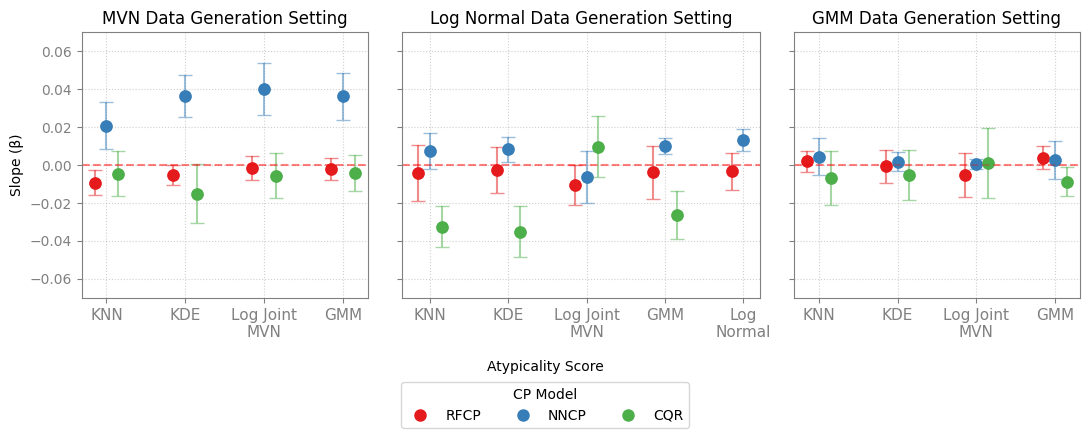

In [ ]:
# Takes 93 minutes to run
beta_df = compute_beta(true_atypicality=False, silent=True)
beta_df.to_csv('../intermediate/3x3_predictedatypicality.csv', index=False)
plot_betagrouped_by_atypicality(beta_df=beta_df, true_atypicality=False, outputfile="3x3_predicted_atypicality.png")

# 3 & 4. Performance metrics and Coverage vs. Beta for values of $\lambda$ 
For the specified atypicality score `atyp_col`, the function `lambda_hyperparameter_tuning` will calculate performance metrics on `y_test`. 
* When `hyperparamter_tuning=True`, the function treats `y_test` like a second calibration set to choose $\lambda$. If `hyperparamter_tuning=False`, then we generate entirely new data on which to calculate coverage for $\lambda$, using offset random seeds. This ensures no data leakage between hyperparameter tuning and evaluation.

It returns the following objects: 
* `lambda_metrics` is a dictionary, where each key refers to a $\lambda$ value and each value refers to a dataframe containing performance metrics
* `lambda_results` is a dataframe of point predictions and $\lambda$-adjusted bounds
* `merged_dfs` is a dictionary, where each key refers to a $\lambda$ value and each value refers to dataframe containing the coverage across atypicality quantile

Things to check:
1. Calibration for $\lambda$ does not use data that was already used to train
2. Change graph to be more aesthetically appealing
3. Change graphs above as well to be more sighlty
4. do I want to allow users to specify how many steps of lambda are tested? how many n_samples? make the inputs into lambda_hyperparameter_tuning more similar to evaluate_...? 


In [ ]:
lambda_metrics, lambda_results, merged_dfs = lambda_hyperparameter_tuning(atyp_col='logjointmvn_score', 
                                                            make_and_split_data=generate_and_split_mvn_data, 
                                                            fit_cp_model=fit_conformal_cp_model, 
                                                            n_splits=5, 
                                                            true_atypicality=True, 
                                                            hyperparameter_tuning=True)
plot_lambda_metrics(lambda_metrics)

In the following code, we use the `lambda_hyperparameter_tuning` with `hyperparamter_tuning=True` to select the best $\lambda$ value. Then, we can evaluate coverage using the best $\lambda$ value on new data. 

In [ ]:
# Function to iterate through the atypicality scores, find the best lambda, and return relevant metrics. 
# atyp_scores = ['knn_score', 'kde_score', 'log_joint_mvn_score', 'gmm_score', 'lognormal_score']
# data_generation_settings = [generate_and_split_mvn_data, generate_and_split_lognormal_data, generate_and_split_gmm_data]
# cp_models = [fit_rf_cp_model, fit_gaussian_cp_model, fit_conformal_cp_model]

atyp_scores = ['knn_score', 'kde_score']
data_generation_settings = [generate_and_split_mvn_data]
cp_models = [fit_rf_cp_model, fit_conformal_cp_model]
true_atypicality = True
n_splits = 1

lambda_metric_results, coverage_results = run_lambda_selection_and_evaluation(atyp_scores, 
                                                                              data_generation_settings, 
                                                                              cp_models, 
                                                                              n_splits, 
                                                                              true_atypicality)

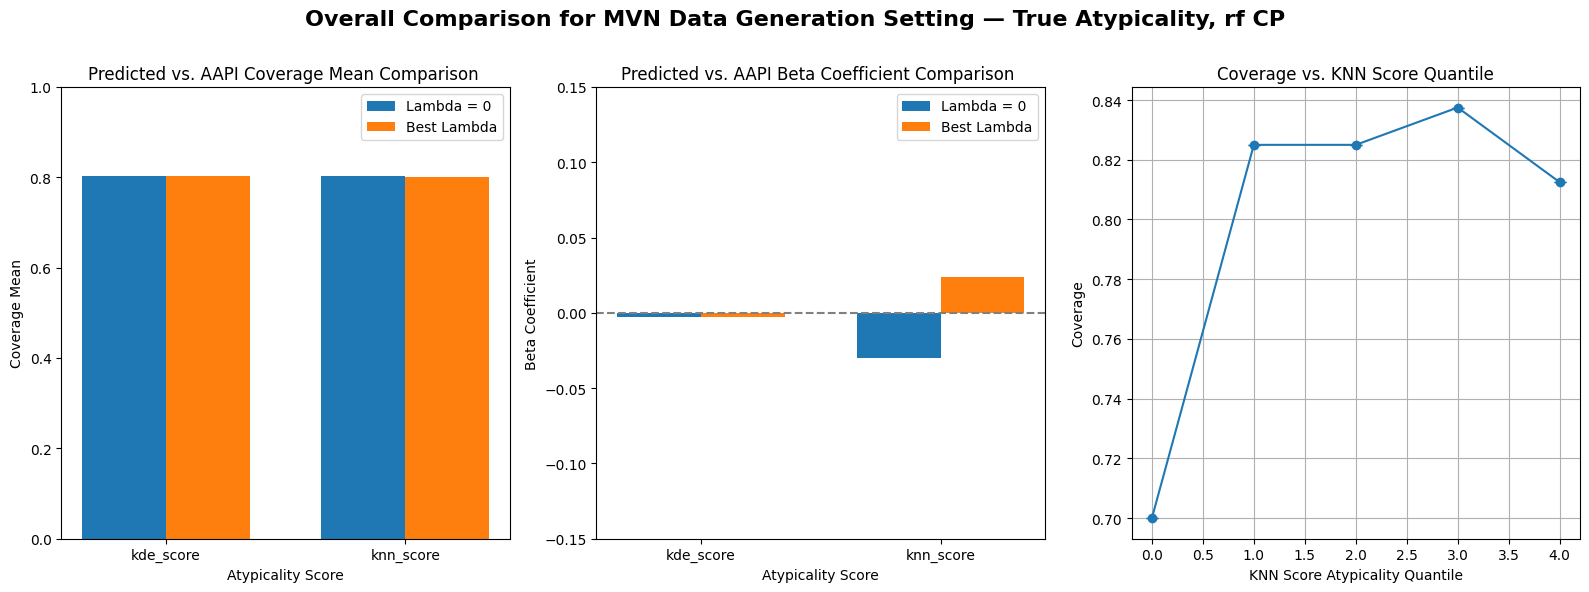

In [ ]:
# atyp_scores = ['knn_score']
# data_generation_settings = [generate_and_split_mvn_data]
# cp_models = [fit_rf_cp_model]

from plotting import plot_datagen_lambda_comparison

plot_datagen_lambda_comparison(lambda_metric_results, 
                               coverage_results,
                               atyp_col = 'knn_score',
                               atypicality_score_title = 'KNN Score',
                               data_generation_setting = generate_and_split_mvn_data,
                               data_generation_setting_title = 'MVN Data Generation Setting',
                               cp_model = fit_rf_cp_model,
                               atypicality_scores = ['knn_score', 'kde_score', 
                                                        'log_joint_mvn_score', 'lognormal_score',
                                                        'gmm_score'],
                               true_atypicality = True)

Next:
* change color of plots - use colab v4 to update the right-most plot of this graph with colors

# Generating Teaser Figure
3 sub-figures to show:
1. atypicality is correlated with lower coverage (beta is negative)
2. atypicality overlaps with underrepresented demographic groups
3. there are points that are in represented groups that are atypical and have low-coverage


In [14]:
# Took 347min to run with 10k samples and 5 splits - gaussian CP
atypicality_settings = [('logjointmvn_score', 0)]
coverage_by_quantile_lambda, df_mimic = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_mimic_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=10000, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=5, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        extra_attribute=True,
                                        silent=True)

# Save results to a pickle file
with open("../intermediate/mimic-n10k/mimic_n10k_dfs_conformal_trueatypicality.pkl", "wb") as f:
    pickle.dump(df_mimic, f)

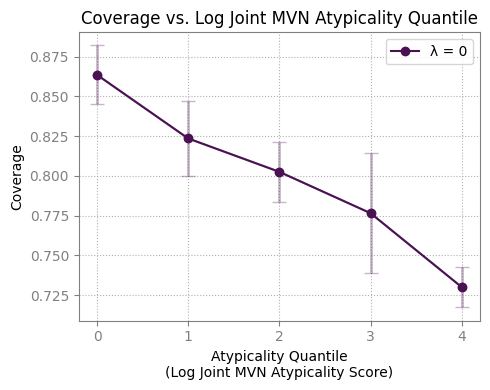

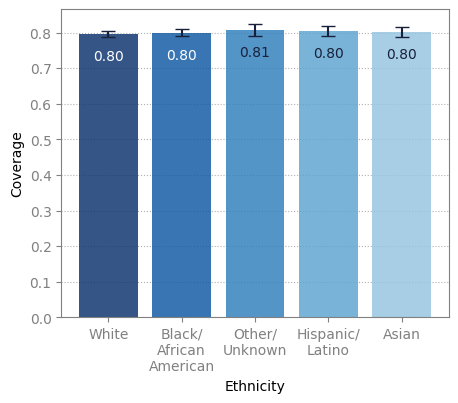

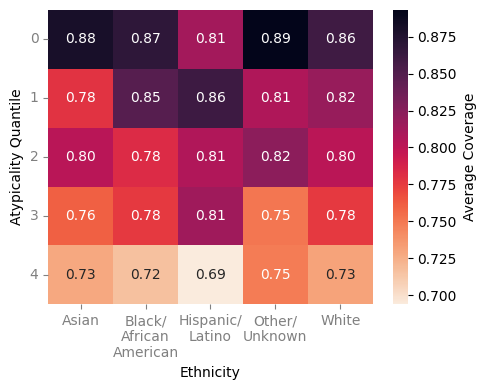

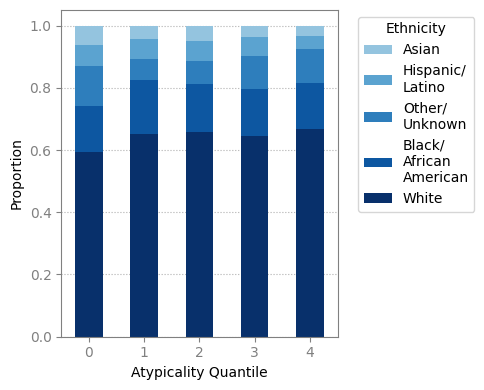

In [16]:
# Re-load pickled file
with open("../intermediate/mimic-n10k/mimic_n10k_dfs_conformal_trueatypicality.pkl", "rb") as f:
    mimic_dfs = pickle.load(f)

# Plot results
ethnicity_map = {
    "WHITE": "White",
    "BLACK/AFRICAN AMERICAN": "Black/\nAfrican\nAmerican",
    "HISPANIC/LATINO": "Hispanic/\nLatino",
    "ASIAN": "Asian",
    "OTHER/UNKNOWN": "Other/\nUnknown"}
desired_order = ["White", "Black/\nAfrican\nAmerican", "Other/\nUnknown", "Hispanic/\nLatino", "Asian"]

plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)
avg_coverage_by_attr_witherror(mimic_dfs['logjointmvn_score_lam0'], attribute_name="Ethnicity", ethnicity_mapping=ethnicity_map, desired_order=desired_order)
heatmap_by_quantile_attribute(mimic_dfs['logjointmvn_score_lam0'], attribute="attr", attribute_name="Ethnicity", ethnicity_mapping=ethnicity_map)
plot_mean_demographic_composition(mimic_dfs['logjointmvn_score_lam0'], ethnicity_map=ethnicity_map, desired_order=desired_order, num_quantiles=5)

### Replicate for predicted atypicality

In [6]:
atypicality_settings = [('logjointmvn_score', 0)]
coverage_by_quantile_lambda, df_mimic_predicted = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_mimic_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=10000, # Number of samples is ignored; real dataset is of fixed size
                                        n_splits=5, 
                                        true_atypicality=False,
                                        num_quantiles=5,
                                        return_df=True,
                                        extra_attribute=True,
                                        silent=True)

# Save results to a pickle file
with open("../intermediate/mimic-n10k/mimic_n10k_dfs_conformal_predictedatypicality.pkl", "wb") as f:
    pickle.dump(df_mimic_predicted, f)

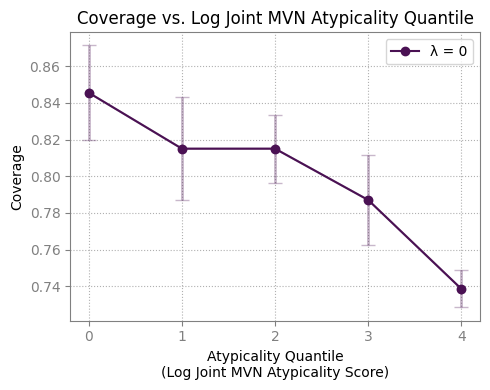

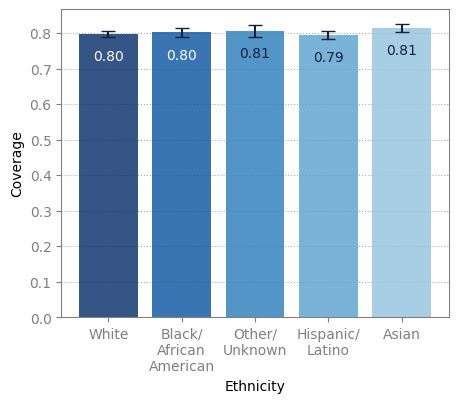

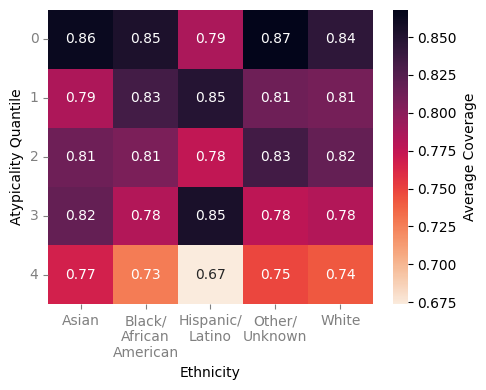

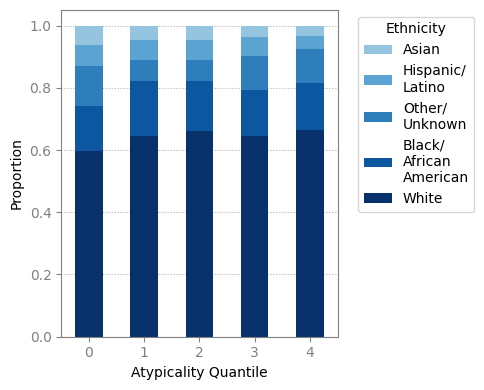

In [7]:
# Re-load pickled file
with open("../intermediate/mimic-n10k/mimic_n10k_dfs_conformal_predictedatypicality.pkl", "rb") as f:
    mimic_predicted_dfs = pickle.load(f)

# Plot results
ethnicity_map = {
    "WHITE": "White",
    "BLACK/AFRICAN AMERICAN": "Black/\nAfrican\nAmerican",
    "HISPANIC/LATINO": "Hispanic/\nLatino",
    "ASIAN": "Asian",
    "OTHER/UNKNOWN": "Other/\nUnknown"}
desired_order = ["White", "Black/\nAfrican\nAmerican", "Other/\nUnknown", "Hispanic/\nLatino", "Asian"]

plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=True)
avg_coverage_by_attr_witherror(mimic_predicted_dfs['logjointmvn_score_lam0'], attribute_name="Ethnicity", ethnicity_mapping=ethnicity_map, desired_order=desired_order)
heatmap_by_quantile_attribute(mimic_predicted_dfs['logjointmvn_score_lam0'], attribute="attr", attribute_name="Ethnicity", ethnicity_mapping=ethnicity_map)
plot_mean_demographic_composition(mimic_predicted_dfs['logjointmvn_score_lam0'], ethnicity_map=ethnicity_map, desired_order=desired_order, num_quantiles=5)

# Implement California Housing Dataset 

In [ ]:
atypicality_settings = [('logjointmvn_score', 0)]
coverage_by_quantile_lambda, df_chd = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_chd_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=20000,
                                        n_splits=5, 
                                        true_atypicality=True,
                                        num_quantiles=5,
                                        return_df=True,
                                        extra_attribute=True,
                                        silent=True)

# Save results to a pickle file
with open("../intermediate/chd_dfs_conformal_atypicality_20k.pkl", "wb") as f:
    pickle.dump(df_chd, f)

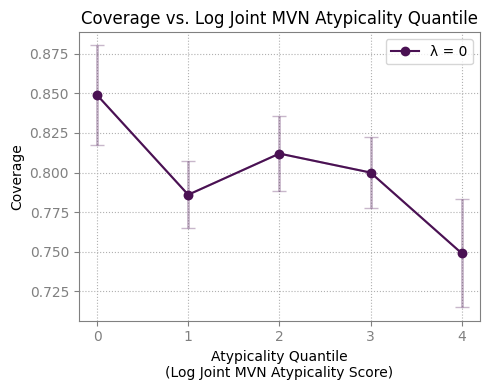

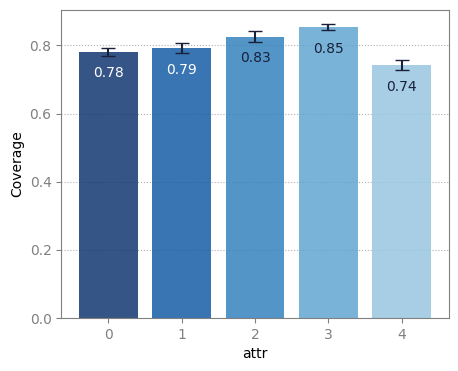

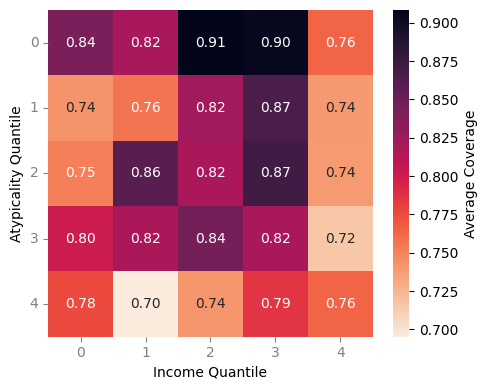

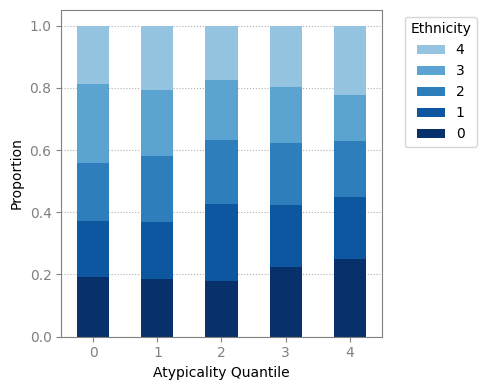

In [ ]:
# Re-load pickled file
with open("../intermediate/chd_dfs_conformal_atypicality_20k.pkl", "rb") as f:
    df_chd_atypicality = pickle.load(f)

# Quantiles correspond to the bins: 4999-23523, 23523-31406, 31406-39670, 39670-51097, 51097-15000
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=False)
avg_coverage_by_attr_witherror(df_chd_atypicality['logjointmvn_score_lam0'], attribute_name="attr")
heatmap_by_quantile_attribute(df_chd_atypicality['logjointmvn_score_lam0'], attribute="attr", attribute_name="Income Quantile")
plot_mean_demographic_composition(df_chd_atypicality['logjointmvn_score_lam0'], attribute_name="Income Quantile", num_quantiles=5)

### Replicate for predicted atypicality

In [ ]:
atypicality_settings = [('logjointmvn_score', 0)]
coverage_by_quantile_lambda, df_chd = evaluate_lambda_adjusted_interval_coverage(atypicality_settings, 
                                        make_and_split_data=load_and_split_chd_data, 
                                        fit_cp_model=fit_conformal_cp_model, 
                                        n_samples=5000,
                                        n_splits=5, 
                                        true_atypicality=False,
                                        num_quantiles=5,
                                        return_df=True,
                                        extra_attribute=True,
                                        silent=True)

# Save results to a pickle file
with open("../intermediate/mimic-n10k/chd_dfs_conformal_atypicality_20k.pkl", "wb") as f:
    pickle.dump(df_chd, f)

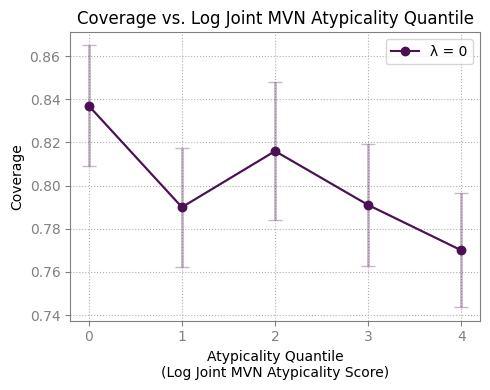

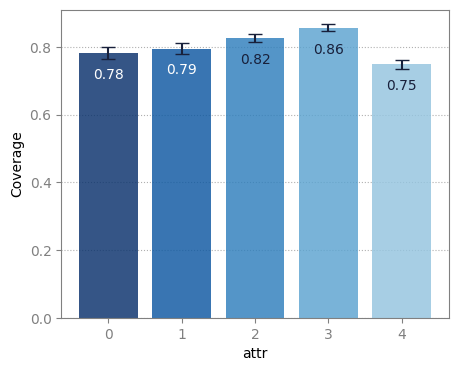

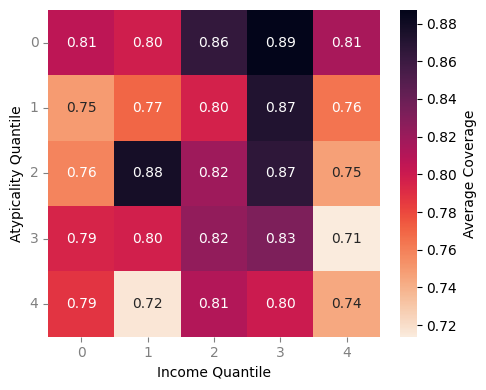

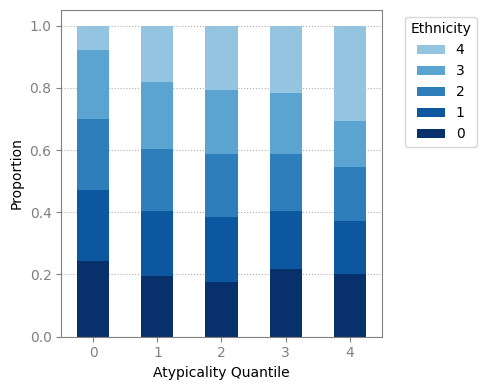

In [ ]:
# Save results to a pickle file
with open("../intermediate/mimic-n10k/chd_dfs_conformal_predictedatypicality_20k.pkl", "wb") as f:
    pickle.dump(df_chd, f)

# Quantiles correspond to the bins: 4999-23523, 23523-31406, 31406-39670, 39670-51097, 51097-15000
plot_coverage_across_atypicality_quantile(df=coverage_by_quantile_lambda,
                                          atypicality_score = "logjointmvn_score",
                                          atypicality_score_title="Log Joint MVN",
                                          ylim_bottom=None,
                                          ylim_top=None,
                                          save=False)
avg_coverage_by_attr_witherror(df_chd['logjointmvn_score_lam0'], attribute_name="attr")
heatmap_by_quantile_attribute(df_chd['logjointmvn_score_lam0'], attribute="attr", attribute_name="Income Quantile")
plot_mean_demographic_composition(df_chd['logjointmvn_score_lam0'], num_quantiles=5)